<a href="https://colab.research.google.com/github/MustafaBozkurt84/predictive-maintanance-LSTM/blob/master/lstm_univariate_timeseries_anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import StandardScaler
%matplotlib inline
%config InlineBackend.figure_format='retina'
import pickle
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)



RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
df =pd.read_csv("/content/drive/MyDrive/Datasets/predictive maintance /31_hidrolikmotoru_analiz.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [41]:
df.drop(["name","partno","balancerbasinci","spm","xkurt"],axis=1,inplace=True)
df.columns=['Time', 'vibx', 'vibz', 'temp', 'zacc', 'zfreq', 'crest']
df["Time"]= [str(i).replace("2020-02-02","2/2/2020").replace("2020-01-02","2/1/2020") for i in df["Time"]]

df['Time'] = pd.to_datetime(df['Time']) 
df['Time']=[str(i).split(":")[0] for i in df["Time"]]
df['Time'] = pd.to_datetime(df['Time'],format="%Y-%m-%d %H") #%Y-%m-%d %H:%M:%S

df=df.groupby("Time").mean()
df.reset_index(inplace=True)

df.to_csv("/content/drive/MyDrive/Datasets/predictive maintance /DataAnaliz.csv")
df.head()

,Time,vibx,vibz,temp,zacc,zfreq,crest
0,2020-01-01 00:00:00,0.154338,0.144321,15.637208,0.041157,0.01,4.111596
1,2020-01-01 01:00:00,0.156064,0.145520,15.373346,0.041440,0.01,4.160439
2,2020-01-01 02:00:00,0.155957,0.146585,15.122024,0.041997,0.01,4.212914
3,2020-01-01 03:00:00,0.155334,0.143598,14.902892,0.043065,0.01,4.331691
4,2020-01-01 04:00:00,0.157375,0.144605,14.703281,0.047041,0.01,4.693571


In [42]:
df['Time'] = pd.to_datetime(df['Time'],format="%Y-%m-%d %H")

# Train Test 

In [43]:
data1=df.copy()

In [44]:
ariza_tarihleri=["2020-01-27 14:00:00","2020-09-11 14:00:00","2020-10-06 18:00:00","2020-10-10 08:00:00","2020-10-13 04:00:00","2020-10-18 00:00:00","2020-10-30 09:00:00","2020-11-02 05:00:00"]
ariza_index = []
for i in ariza_tarihleri:
  ariza_index.append(df[df["Time"]==i].index[0])

In [45]:
drop_index_list=[]
for a in ariza_index:

  for i in range(0,24*7):
    drop_index_list.append(a+i)
  for i in range(0,24*2):
    drop_index_list.append(a-i)

In [46]:
df.drop(index=drop_index_list,axis=0,inplace=True)
df.reset_index(drop=True,inplace=True)

In [47]:
data =df.copy()

In [48]:
ariza_tarihleri=["2020-01-27 14:00:00","2020-09-11 14:00:00","2020-10-06 18:00:00","2020-10-10 08:00:00","2020-10-13 04:00:00","2020-10-18 00:00:00","2020-10-30 09:00:00","2020-11-02 05:00:00"]

In [49]:
def pickle_all(key,value):
         pickle_out = open(key, "wb")
         pickle.dump(value, pickle_out)
         pickle_out.close()

In [50]:
# convert an array of values into a dataset matrix
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [86]:
def lstm_anomaly(df,col,date,time_step,threshold):
    print(f"{col}"+50*"*")
    df  = data.copy()
    df.set_index("Time",inplace=True)
    df1=df[[col]]
    df2=data1.copy()
    print(df2)
    df2.set_index("Time",inplace= True)
    print(df2)
    df3=df2[[col]]
    train_size=df2.shape[0]
    train, test = df1.iloc[24*30:train_size], df3[df3.index>"2020-01-01 15:00:00"]
    print(train.shape, test.shape)
    # reshape into X=t,t+1,t+2,t+3 and Y=t+4
    

    scaler = StandardScaler()
    scaler = scaler.fit(train[[col]])

    train[col] = scaler.transform(train[[col]])
    test[col] = scaler.transform(test[[col]])
    pickle_all(f"/content/drive/MyDrive/model_predictive_maintanence/{col}_scaler_lstm_univarate.pkl",scaler)    
           
    TIME_STEPS = time_step
    
    # reshape to [samples, time_steps, n_features]

    X_train, y_train = create_dataset(train[[col]], train[col], TIME_STEPS)
    X_test, y_test = create_dataset(test[[col]], test[col], TIME_STEPS)

    print(X_train.shape)

    model = keras.Sequential()
    model.add(keras.layers.LSTM(
            units=64, 
            input_shape=(X_train.shape[1], X_train.shape[2])
        ))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
    model.add(keras.layers.LSTM(units=64, return_sequences=True))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
    model.compile(loss='mae', optimizer='adam')
        
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.1,
        shuffle=False,verbose=1
    )
   
    model.save(f"/content/drive/MyDrive/model_predictive_maintanence/{col}_anomaly_model.h5")
    X_train_pred = model.predict(X_train)

    train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
    
    X_test_pred = model.predict(X_test)

    test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
    
    THRESHOLD = threshold

    test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
    test_score_df['loss'] = test_mae_loss
    test_score_df['threshold'] = THRESHOLD
    test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
    test_score_df[col] = test[TIME_STEPS:][col]
    
    anomalies = test_score_df[test_score_df.anomaly == True]
    
    train_score_df = pd.DataFrame(index=train[TIME_STEPS:].index)
    train_score_df['loss'] = train_mae_loss
    train_score_df['threshold'] = THRESHOLD
    train_score_df['anomaly'] = train_score_df.loss > train_score_df.threshold
    train_score_df[col] = train[TIME_STEPS:][col]
    
    anomalies_train = train_score_df[train_score_df.anomaly == True]
    
    return anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler

In [87]:
def loss_and_threshold_value_plot():
    plt.plot(test_score_df.index, test_score_df.loss, label='loss_'+col)
    plt.plot(test_score_df.index, test_score_df.threshold, label='threshold_'+col)
    plt.xticks(rotation=25)
    plt.legend();

In [88]:
def train_mae_loss():
    sns.distplot(train_mae_loss, bins=50, kde=True);


In [89]:
def anomaly_plot(test,anomalies,col):
    ariza_tarihleri_plot= []
    for i in [str(a) for a in data1["Time"]]:
          if i not in [str(b) for b in ariza_tarihleri]:
            ariza_tarihleri_plot.append(data1[col].min())
          else:
            ariza_tarihleri_plot.append(data1[col].max())
    ariza=pd.DataFrame(ariza_tarihleri_plot)
    ariza.index=data1["Time"]
    ariza.columns=["ariza tarihleri"]

    print(anomalies.head(10))
    plt.figure(figsize=(24, 12), dpi=80)
    plt.plot(
          test[TIME_STEPS:].index, 
          scaler.inverse_transform(test[TIME_STEPS:][col]), 
          label=col
        );

    sns.scatterplot(
          anomalies.index,
          scaler.inverse_transform(anomalies[col]),
          color=sns.color_palette()[3],
          s=52,
          label='anomaly_'+col
        )
    plt.plot(ariza["ariza tarihleri"],label="ariza tarihleri")
    plt.xticks(rotation=25)
    plt.legend();
    plt.show()

In [90]:
def loss_plot():
    plt.plot(history.history['loss'], label='train loss_'+col)
    plt.plot(history.history['val_loss'], label='test loss_'+col)
    plt.legend();


In [91]:
total_anomalies = pd.DataFrame()


# vibx 

In [92]:
anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler= lstm_anomaly(df,col="vibx",date="2021-01-10 04:00:00", time_step=20, threshold=1.9)
anomalyy= anomalies.reset_index()
anomalyy["anomaly_count"]=[1 for i in range(anomalies.shape[0])]
total_anomalies = pd.concat((total_anomalies,anomalyy),axis=0)

vibx**************************************************
                    Time      vibx      vibz  ...      zacc     zfreq     crest
0    2020-01-01 00:00:00  0.154338  0.144321  ...  0.041157  0.010000  4.111596
1    2020-01-01 01:00:00  0.156064  0.145520  ...  0.041440  0.010000  4.160439
2    2020-01-01 02:00:00  0.155957  0.146585  ...  0.041997  0.010000  4.212914
3    2020-01-01 03:00:00  0.155334  0.143598  ...  0.043065  0.010000  4.331691
4    2020-01-01 04:00:00  0.157375  0.144605  ...  0.047041  0.010000  4.693571
...                  ...       ...       ...  ...       ...       ...       ...
7123 2021-01-22 02:00:00  1.696243  1.339870  ...  0.669262  0.134723  5.019967
7124 2021-01-22 03:00:00  1.638439  1.249788  ...  0.652285  0.130145  5.058305
7125 2021-01-22 04:00:00  1.624994  1.199024  ...  0.641953  0.128047  5.066521
7126 2021-01-22 05:00:00  1.639610  1.219718  ...  0.643970  0.129403  5.031291
7127 2021-01-22 06:00:00  1.616865  1.137539  ...  0.644223  0.12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(6388, 20, 1)
Epoch 1/50
180/180 [==============================] - 9s 30ms/step - loss: 0.2716 - val_loss: 0.1684
Epoch 2/50
180/180 [==============================] - 4s 24ms/step - loss: 0.2152 - val_loss: 0.1451
Epoch 3/50
180/180 [==============================] - 4s 24ms/step - loss: 0.1956 - val_loss: 0.1399
Epoch 4/50
180/180 [==============================] - 4s 24ms/step - loss: 0.1869 - val_loss: 0.1306
Epoch 5/50
180/180 [==============================] - 4s 24ms/step - loss: 0.1792 - val_loss: 0.1289
Epoch 6/50
180/180 [==============================] - 4s 24ms/step - loss: 0.1756 - val_loss: 0.1237
Epoch 7/50
180/180 [==============================] - 4s 24ms/step - loss: 0.1702 - val_loss: 0.1233
Epoch 8/50
180/180 [==============================] - 4s 24ms/step - loss: 0.1684 - val_loss: 0.1221
Epoch 9/50
180/180 [==============================] - 4s 24ms/step - loss: 0.1683 - val_loss: 0.1266
Epoch 10/50
180/180 [==============================] - 4s 24ms/step - loss: 0

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


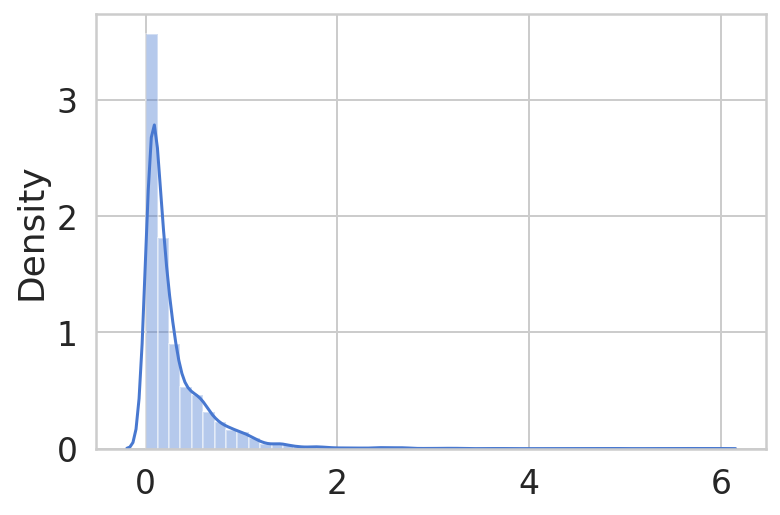

In [93]:
sns.distplot(train_mae_loss, bins=50, kde=True)

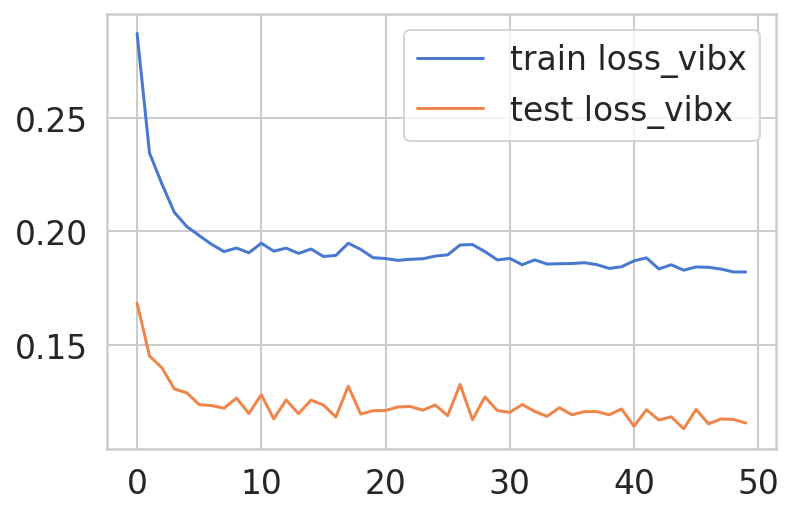

In [94]:
loss_plot()

                         loss  threshold  anomaly      vibx
Time                                                       
2020-09-19 22:00:00  2.434142        1.9     True -1.003139
2020-09-19 23:00:00  2.601454        1.9     True -1.003044
2020-09-20 00:00:00  2.437850        1.9     True -1.004568
2020-09-20 01:00:00  2.289415        1.9     True -1.005579
2020-09-20 02:00:00  2.149514        1.9     True  0.269166
2020-09-20 22:00:00  2.451650        1.9     True  2.097607
2020-09-20 23:00:00  2.510516        1.9     True  2.170156
2020-09-21 00:00:00  2.405491        1.9     True  1.608760
2020-09-21 01:00:00  2.076658        1.9     True  1.243069
2020-09-21 03:00:00  1.972916        1.9     True  2.231503


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


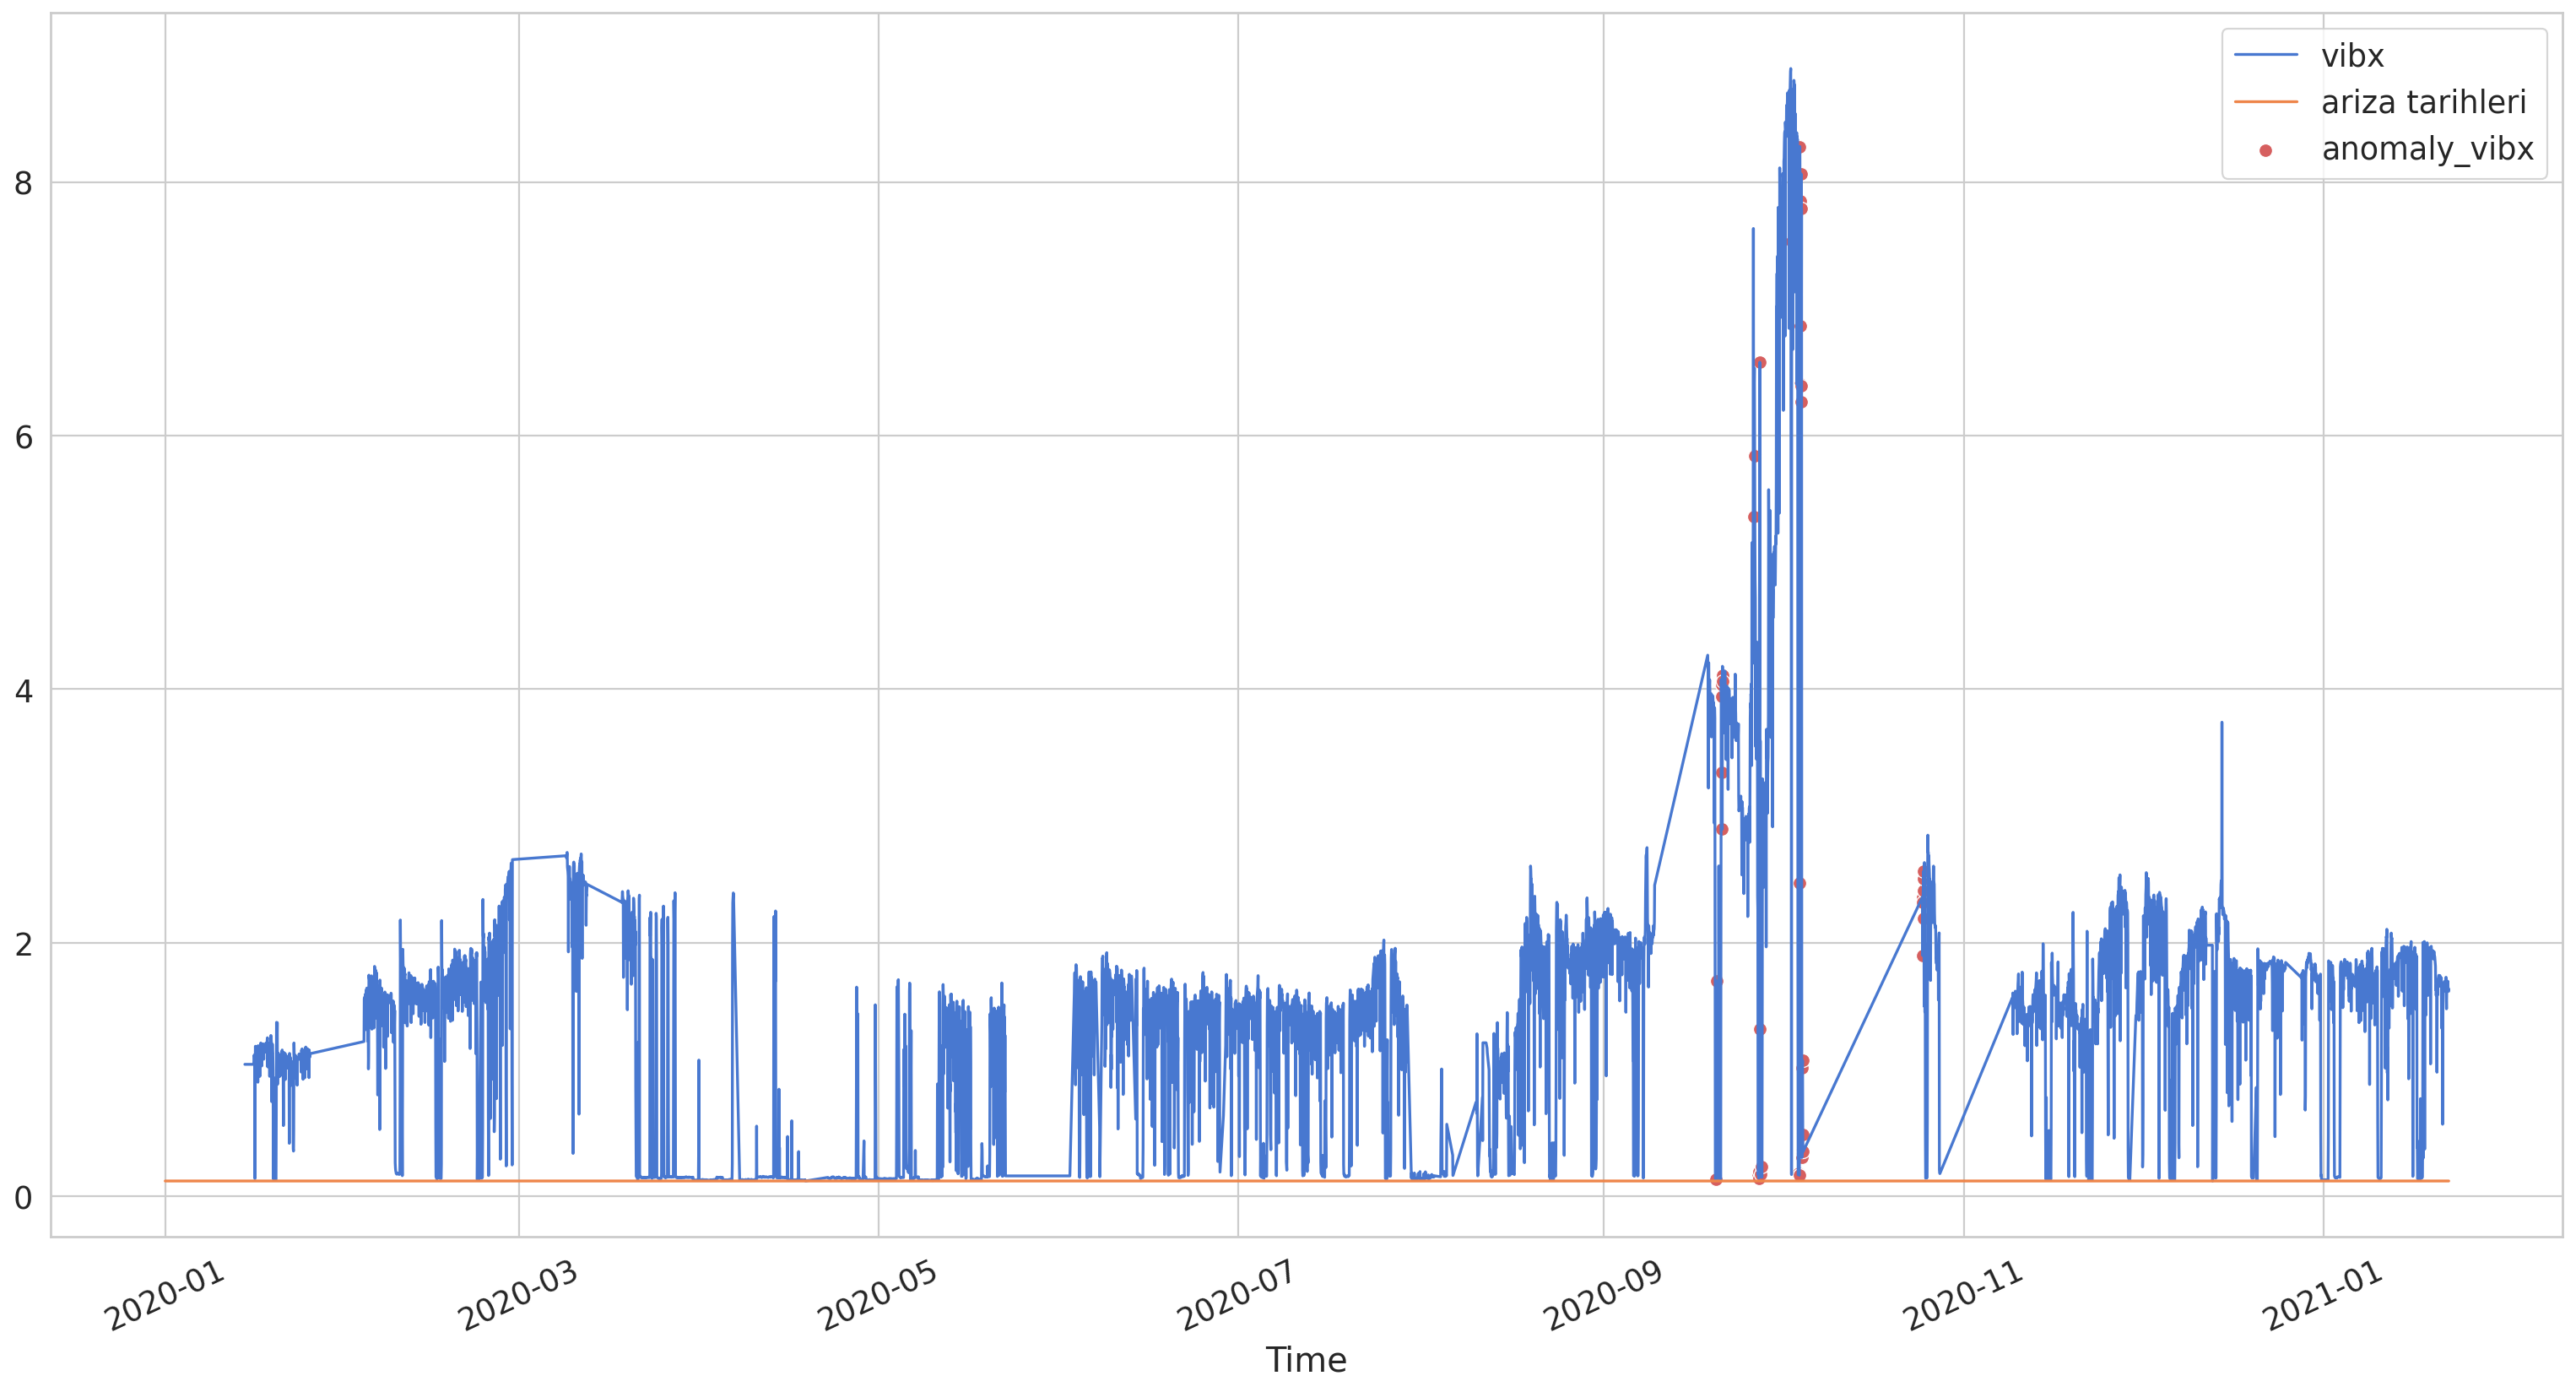

In [95]:
anomaly_plot(test,anomalies=anomalies,col="vibx")

# vibz

In [ ]:
anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler= lstm_anomaly(df,col="vibz",date="2021-01-10 04:00:00",time_step=20,threshold=1.9)
anomalyy= anomalies.reset_index()
anomalyy["anomaly_count"]=[1 for i in range(anomalies.shape[0])]
total_anomalies = pd.concat((total_anomalies,anomalyy),axis=0)

vibz**************************************************
                    Time      vibx      vibz  ...      zacc     zfreq     crest
0    2020-01-01 00:00:00  0.154338  0.144321  ...  0.041157  0.010000  4.111596
1    2020-01-01 01:00:00  0.156064  0.145520  ...  0.041440  0.010000  4.160439
2    2020-01-01 02:00:00  0.155957  0.146585  ...  0.041997  0.010000  4.212914
3    2020-01-01 03:00:00  0.155334  0.143598  ...  0.043065  0.010000  4.331691
4    2020-01-01 04:00:00  0.157375  0.144605  ...  0.047041  0.010000  4.693571
...                  ...       ...       ...  ...       ...       ...       ...
7123 2021-01-22 02:00:00  1.696243  1.339870  ...  0.669262  0.134723  5.019967
7124 2021-01-22 03:00:00  1.638439  1.249788  ...  0.652285  0.130145  5.058305
7125 2021-01-22 04:00:00  1.624994  1.199024  ...  0.641953  0.128047  5.066521
7126 2021-01-22 05:00:00  1.639610  1.219718  ...  0.643970  0.129403  5.031291
7127 2021-01-22 06:00:00  1.616865  1.137539  ...  0.644223  0.12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(6388, 20, 1)
Epoch 1/50
180/180 [==============================] - 8s 28ms/step - loss: 0.2018 - val_loss: 0.1641
Epoch 2/50
180/180 [==============================] - 4s 23ms/step - loss: 0.1586 - val_loss: 0.1427
Epoch 3/50
180/180 [==============================] - 4s 23ms/step - loss: 0.1462 - val_loss: 0.1382
Epoch 4/50
180/180 [==============================] - 4s 23ms/step - loss: 0.1412 - val_loss: 0.1505
Epoch 5/50
180/180 [==============================] - 4s 23ms/step - loss: 0.1407 - val_loss: 0.1322
Epoch 6/50
180/180 [==============================] - 4s 23ms/step - loss: 0.1362 - val_loss: 0.1317
Epoch 7/50
180/180 [==============================] - 4s 23ms/step - loss: 0.1335 - val_loss: 0.1290
Epoch 8/50
180/180 [==============================] - 4s 23ms/step - loss: 0.1322 - val_loss: 0.1305
Epoch 9/50
180/180 [==============================] - 4s 24ms/step - loss: 0.1313 - val_loss: 0.1294
Epoch 10/50
180/180 [==============================] - 4s 23ms/step - loss: 0

In [ ]:
sns.distplot(train_mae_loss, bins=50, kde=True)

In [ ]:
loss_plot()

In [ ]:
anomaly_plot(test,anomalies=anomalies,col="vibz")

# temp

In [ ]:
anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler= lstm_anomaly(df,col="temp",date="2021-01-10 04:00:00",time_step=20,threshold=1.5)
anomalyy= anomalies.reset_index()
anomalyy["anomaly_count"]=[1 for i in range(anomalies.shape[0])]
total_anomalies = pd.concat((total_anomalies,anomalyy),axis=0)

In [ ]:
sns.distplot(train_mae_loss, bins=50, kde=True)

In [ ]:
loss_plot()

In [ ]:
anomaly_plot(test,anomalies=anomalies,col="temp")

# zacc

In [ ]:
anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler= lstm_anomaly(df,col="zacc",date="2021-01-10 04:00:00",time_step=20,threshold=2.5)
anomalyy= anomalies.reset_index()
anomalyy["anomaly_count"]=[1 for i in range(anomalies.shape[0])]
total_anomalies = pd.concat((total_anomalies,anomalyy),axis=0)

In [ ]:
sns.distplot(train_mae_loss, bins=50, kde=True)

In [ ]:
loss_plot()

In [ ]:
anomaly_plot(test,anomalies=anomalies,col="zacc")

# crest

In [ ]:
anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler= lstm_anomaly(df,col="crest",date="2021-01-10 04:00:00",time_step=20,threshold=4)
anomalyy= anomalies.reset_index()
anomalyy["anomaly_count"]=[1 for i in range(anomalies.shape[0])]
total_anomalies = pd.concat((total_anomalies,anomalyy),axis=0)

In [ ]:
sns.distplot(train_mae_loss, bins=50, kde=True)

In [ ]:
loss_plot()

In [ ]:
anomaly_plot(test,anomalies=anomalies,col="crest")

# zfreq

In [ ]:
anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler= lstm_anomaly(df,col="zfreq",date="2021-01-10 04:00:00",time_step=20,threshold=3.2)
anomalyy= anomalies.reset_index()
anomalyy["anomaly_count"]=[1 for i in range(anomalies.shape[0])]
total_anomalies = pd.concat((total_anomalies,anomalyy),axis=0)

In [ ]:
sns.distplot(train_mae_loss, bins=50, kde=True)

In [ ]:
loss_plot()

In [ ]:
anomaly_plot(test,anomalies=anomalies,col="zfreq")

In [ ]:
ariza_tarihleri_plot= []
for i in [str(a) for a in data["Time"]]:
          if i not in [str(b) for b in ariza_tarihleri]:
            ariza_tarihleri_plot.append(data[col].min())
          else:
            ariza_tarihleri_plot.append(data[col].max())
ariza=pd.DataFrame(ariza_tarihleri_plot)
ariza.index=data["Time"]
ariza.columns=["ariza tarihleri"]

In [ ]:
total_anomalies.groupby("Time")["anomaly_count"].sum().plot()
ariza["ariza tarihleri"].plot()

In [ ]:
total_anomalies["Time"].value_counts()

In [ ]:
total_anomalies.to_csv("total_anomaly.csv")